# Timemap Histogram 

-------------------------------------------------

The raw code for this Jupyter notebook is on by default. The focus of this notebook walking through the process and code that leads to the final data and graph. If you only came for the graphs . To toggle on/off the raw code, click below:

In [1]:
# Setup Code toggle button
from IPython.core.display import HTML  

HTML(''' 
<center><h3>
<a href="javascript:code_toggle()">Code is cheap, show me the data.</a>
</center></h3>
<script>
    var code_show=false; //false -> show code at first

    function code_toggle() {
        $('div.prompt').hide(); // always hide prompt

        if (code_show){
            $('div.input').hide();
        } else {
            $('div.input').show();
        }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>
''')

In [2]:
# Offline mode
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Load R magic
%load_ext rpy2.ipython

# 22.01.2017
# Disable warnings because of nx.draw() output:
#     warnings.warn("axes.hold is deprecated, will be removed in 3.0")
import warnings
warnings.filterwarnings('ignore')

# Setup notebook theme
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme(get_themes()[2])

&nbsp;
## Contents

*  [Clean up the Data](#cleanup)
*  [Timemap URIs](#timemap)
*  [Graph Section](#graphs)

  *  [Python Plotly graph](#python_plotly)
  *  [Standard R graph](#R)
  *  [ggplot R graph](#ggplot)
  *  [R Plotly graph (external)](histogram.html)


<a id='cleanup'></a>
## Cleaning up the Data

&nbsp;

In [3]:
link_path = '../data/link_list.dat'
with open(link_path) as link_file:
    init_links = [link.strip().lower() for link in link_file]

print("A sample of the links:\n")
for link in init_links[20:25]:
    print('\t' + link)
    
print("\nNumber of links: {}".format(len(init_links)))

A sample of the links:

	www.tweetcaster.com
	www.meetup.com/camcreatives
	www.traceynoelleluz.com
	www.paulspoerry.com
	www.youtube.com/channel/ucbhxbqegrl5etgdpzpvt5fw

Number of links: 2001


&nbsp;

Now we have a list of links, but more than we need. This is good because as we can see from the sample output we likely have links that are not relevant to the target topic, and also there are probably also some near matches that are actually the same content, such as links to different areas on the same page. We can deal with the latter using the [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy) Python library to do fuzzy string matching.

&nbsp;

In [4]:
import itertools
from fuzzywuzzy import fuzz

links_ratio = []
for this_link, that_link in itertools.combinations(init_links, 2):
    ratio = fuzz.ratio(this_link, that_link)
    links_ratio.append((ratio, (this_link, that_link)))
    if ratio > 85:
        print("Ratio: " + str(ratio) + '\n' + \
              this_link + '\n' + \
              that_link + '\n\n')

Ratio: 97
www.google.com/
www.google.com


Ratio: 88
www.google.com/
www.google.com.tr


Ratio: 89
www.entrepreneur.com/article/283815
www.entrepreneur.com/article/250265


Ratio: 89
www.entrepreneur.com/article/283815
www.entrepreneur.com/article/282077


Ratio: 93
www.thenation.com/article/house-republicans-just-voted-to-eliminate-the-only-federal-agency-that-makes-sure-voting-machines-cant-be-hacked/
www.thenation.com/article/house-republicans-just-voted-to-eliminate-the-only-federal-agency-that-makes-sure-voting-machines-cant-be-hacked/?utm_source=sailthru


Ratio: 87
www.thenation.com/article/house-republicans-just-voted-to-eliminate-the-only-federal-agency-that-makes-sure-voting-machines-cant-be-hacked/
www.thenation.com/article/house-republicans-just-voted-to-eliminate-the-only-federal-agency-that-makes-sure-voting-machines-cant-be-hacked/?utm_source=twitter&utm_medium=socialflow


Ratio: 88
www.wral.com/
www.wgal.com


Ratio: 90
www.linkedin.com/profile/public-profile-settings?

&nbsp;

From the results the ratio the division between links that are actually the same page and those that are not is right at 90. By packaging these neatly they can neatly be be sorted out by flipping a coin what to keep using the `random` library.

&nbsp;

In [5]:
import random

links = init_links

# Note: if this block is ran consecutively
# without reseting `links_ratio` to the
# original data from the last block, it will
# continue to remove data that should be kept.
for ratio, link_pair in links_ratio:
    if ratio >= 90:
        try:
            loser = random.choice(link_pair)
            links.remove(loser)
        except ValueError:
            continue
            
print("Now we have {} links".format(len(links)))

Now we have 1925 links


&nbsp;

Well that hardly did anything, still need to ditch 925 URIs. From the sample many look like they are off topic, `fuzzywuzzy` can also be used to search for keywords in the urls. It would also be good to nuke anything linking back into twitter.

&nbsp;

In [6]:
from fuzzywuzzy import process

keywords = [ 'hacker', 'hacking', 'hacked', 'security',
             'programming', 'malware', 'hack', 'hacktivist',
             'cybersecurity', 'cyber', 'red-team', 'backdoor',
             '0day', 'zeroday', 'zero-day', 'infosec',
             'opsec', 'botnet', 'bots', 'pentesting', 'pentest',
             'ransomware', 'osint', 'phishing', 'shodan',
             'rootkit', 'jailbreak', 'gsm', 'car', 'ssh', 'server',
             'camera', 'keylogger', 'embedded', 'exploit',
             'aircraft', 'boat', 'ship', 'satellite', 'iridium'
           ]

top_links = []
for keyword in keywords:
    top_100 = process.extract(keyword, links, limit=50)
    print('.', end=' ')
    top_links += top_100

print('\n')
    
fuzzed_links = list(set([link[0] for link in top_links]))
for link in fuzzed_links:
    if 'twitter' in link:
        print('.', end=' ')
        fuzzed_links.remove(link)

print("\n\nNow we have {} links".format(len(fuzzed_links)))

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

Now we have 1009 links


&nbsp;

Close enough, just grab 1000 and run with it.

&nbsp;

In [7]:
final_links = random.sample(fuzzed_links, 1000)

print("Now we have {} links:\n\n".format(len(final_links)))

for link in final_links:
    print(link)

Now we have 1000 links:


www.werkenbijdeloitte.nl
www.linkedin.com/today/author/jamesljohnson
www.scmagazine.com/david-beckhams-emails-hacked-and-released-after-ransom-refusal/article/636560/?dcmp=emc-scus_newswire&spmailingid=16524299&spuserid=mzqzmze2nju5ota3s0&spjobid=960720405&spreportid=otywnziwnda1s0
www.systron.hu
www.tripwire.com/state-of-security/featured/french-man-sues-uber-after-privacy-bug-led-wife-to-suspect-adultery/
www.vanguardngr.com
www.bitfeed.co/
www.cpgconnect.ca
www.cartoonnetwork.com
www.instagram.com/hackedbystacy/
www.avst.com/products/cx-e/
www.stickleyonsecurity.com
www.redhawksecurity.com
www.nathaliezeitoun.com/
www.reddit.com/r/jailbreak/comments/5t0cwz/news_openssh_updated_should_be_out_soon/?st=iyyn5eo0&sh=ff794535
www.instagram.com/fitperonotanto/
www.punchng.com
www.maastrichtuniversity.nl/ecpc
www.redport-ia.com
www.kettlebellkitchen.com
www.solarwindsmsp.com
www.scmagazine.com/attackers-steal-from-atms-after-infecting-banks-with-memory-only-malware

<a id='timemap'></a>
## Timemap URIs

To begin we need to find a website that has been mostly overlooked or is somewhat new to get a human countable test for extracting the number of mementos. Luckily offensive security recently set up the *megacorpone.com* website for people working on their Offensive Security Certified Profesional (OSCP) certification to play with. At the time of writing there are only 9 mementos.

&nbsp;

In [8]:
import requests
from pprint import pprint
from collections import Counter

url = "http://memgator.cs.odu.edu/timemap/json/https://megacorpone.com"
mementos = requests.get(url).json()

pprint(mementos)

{'mementos': {'first': {'datetime': '2013-06-11T20:00:30Z',
                        'uri': 'http://web.archive.org/web/20130611200030/http://www.megacorpone.com'},
              'last': {'datetime': '2016-03-05T20:02:38Z',
                       'uri': 'http://web.archive.org/web/20160305200238/http://www.megacorpone.com/'},
              'list': [{'datetime': '2013-06-11T20:00:30Z',
                        'uri': 'http://web.archive.org/web/20130611200030/http://www.megacorpone.com'},
                       {'datetime': '2013-11-23T07:12:17Z',
                        'uri': 'http://web.archive.org/web/20131123071217/http://www.megacorpone.com/'},
                       {'datetime': '2014-02-19T07:24:38Z',
                        'uri': 'http://web.archive.org/web/20140219072438/http://www.megacorpone.com/'},
                       {'datetime': '2014-12-28T18:00:46Z',
                        'uri': 'http://web.archive.org/web/20141228180046/http://www.megacorpone.com/'},
              

In [9]:
num_mementos = len(mementos['mementos']['list'])

print("Numer of mementos: {}".format(num_mementos))

Numer of mementos: 9


&nbsp;

Ok, now we know we have a working method for extracting the correct number of mementos for a given URI. All that we need to do is put it in a function and wrap it in a loop over a list of urls to get the needed data. This could be done with [the Pandas library](http://pandas.pydata.org/) but there isn't much data, and each datapoint only has one attribute, so that seems like overkill. I feel like `(link, num_mementos)` tuples are appropriate here.

&nbsp;

In [10]:
def get_num_mementos(link):
    url = 'http://memgator.cs.odu.edu/timemap/json/http://' + link
    try:
        mementos = requests.get(url).json()
    except ValueError as e:
        print("No memento for URL: {}".format(link))
        return 0
    num_mementos = len(mementos['mementos']['list'])
    return num_mementos

link_mementos = []
for link in final_links:
    link_mementos.append((link, get_num_mementos(link)))

No memento for URL: www.linkedin.com/today/author/jamesljohnson
No memento for URL: www.scmagazine.com/david-beckhams-emails-hacked-and-released-after-ransom-refusal/article/636560/?dcmp=emc-scus_newswire&spmailingid=16524299&spuserid=mzqzmze2nju5ota3s0&spjobid=960720405&spreportid=otywnziwnda1s0
No memento for URL: www.instagram.com/hackedbystacy/
No memento for URL: www.nathaliezeitoun.com/
No memento for URL: www.reddit.com/r/jailbreak/comments/5t0cwz/news_openssh_updated_should_be_out_soon/?st=iyyn5eo0&sh=ff794535
No memento for URL: www.instagram.com/fitperonotanto/
No memento for URL: www.maastrichtuniversity.nl/ecpc
No memento for URL: www.scmagazine.com/attackers-steal-from-atms-after-infecting-banks-with-memory-only-malware/article/637029/
No memento for URL: www.facebook.com/tenhopingodesorte/
No memento for URL: www.linkedin.com/company/pgicyber
No memento for URL: www.facebook.com/surwillconsulting
No memento for URL: www.washingtonpost.com/news/powerpost/wp/2017/01/25/sena

&nbsp;

So there are lots of URIs with zero mementos, but what is the max which will define the right end of the graph? While that is being done we can print the `(link, num_mementos)` tuples to browse and double check everything is alright.

&nbsp;

In [11]:
max_mementos = max([x[1] for x in link_mementos])
print("The maximum number of mementos is: {}\n\n".format(max_mementos))

for link in link_mementos:
    print(link)

The maximum number of mementos is: 185303


('www.werkenbijdeloitte.nl', 203)
('www.linkedin.com/today/author/jamesljohnson', 0)
('www.scmagazine.com/david-beckhams-emails-hacked-and-released-after-ransom-refusal/article/636560/?dcmp=emc-scus_newswire&spmailingid=16524299&spuserid=mzqzmze2nju5ota3s0&spjobid=960720405&spreportid=otywnziwnda1s0', 0)
('www.systron.hu', 21)
('www.tripwire.com/state-of-security/featured/french-man-sues-uber-after-privacy-bug-led-wife-to-suspect-adultery/', 1)
('www.vanguardngr.com', 12866)
('www.bitfeed.co/', 6)
('www.cpgconnect.ca', 198)
('www.cartoonnetwork.com', 15546)
('www.instagram.com/hackedbystacy/', 0)
('www.avst.com/products/cx-e/', 74)
('www.stickleyonsecurity.com', 45)
('www.redhawksecurity.com', 54)
('www.nathaliezeitoun.com/', 0)
('www.reddit.com/r/jailbreak/comments/5t0cwz/news_openssh_updated_should_be_out_soon/?st=iyyn5eo0&sh=ff794535', 0)
('www.instagram.com/fitperonotanto/', 0)
('www.punchng.com', 11385)
('www.maastrichtuniversity.nl/ecpc

&nbsp;

Before graphing generate a list of `(x, y)` values to see what kind of graph should be expected.

&nbsp;

In [12]:
# Get all possible numbers of mementos
for link, mementos in link_mementos:
    valid_counts = [x[1] for x in link_mementos]
valid_counts = list(set(valid_counts))

# Parallel list to `valid_counts`
totals = []

# Tally up number of links with each count of mementos
for count in valid_counts:
    count_total = 0
    # Calculate number of links with `count`
    for link, mementos in link_mementos:
        if mementos == count:
            count_total += 1
    totals.append(count_total)

# Zip the parallel lists together
# to produce [(count, total)]
xs_ys = list(zip(valid_counts, totals))

for x_y in xs_ys:
    print(x_y)

(0, 373)
(1, 35)
(2, 22)
(3, 9)
(4, 22)
(5, 16)
(6, 9)
(7, 15)
(8, 11)
(9, 8)
(10, 4)
(11, 7)
(12, 4)
(13, 9)
(14, 9)
(15, 6)
(16, 8)
(17, 8)
(528, 2)
(19, 6)
(7700, 1)
(21, 5)
(22, 7)
(23, 2)
(24, 6)
(25, 4)
(26, 7)
(27, 3)
(28, 3)
(29, 3)
(30, 3)
(31, 1)
(25631, 1)
(32, 5)
(33, 2)
(58915, 1)
(36, 3)
(37, 2)
(38, 5)
(39, 2)
(40, 3)
(41, 5)
(42, 2)
(43, 7)
(44, 3)
(45, 3)
(1581, 1)
(559, 1)
(48, 2)
(555, 1)
(50, 2)
(51, 2)
(52, 1)
(53, 2)
(54, 3)
(565, 1)
(56, 2)
(1080, 1)
(58, 2)
(59, 2)
(60, 1)
(61, 4)
(62, 1)
(57, 1)
(2615, 1)
(1596, 1)
(12866, 1)
(67, 1)
(66, 1)
(1090, 1)
(70, 2)
(71, 3)
(72, 2)
(73, 1)
(74, 1)
(75, 2)
(77, 1)
(79, 3)
(80, 1)
(3663, 1)
(81, 3)
(83, 1)
(84, 3)
(85, 2)
(86, 2)
(87, 2)
(2560, 1)
(602, 1)
(18, 4)
(92, 1)
(93, 2)
(94, 2)
(606, 1)
(96, 1)
(608, 1)
(607, 1)
(99, 1)
(100, 3)
(6245, 1)
(20, 5)
(103, 3)
(104, 3)
(105, 1)
(110, 1)
(111, 1)
(15472, 1)
(113, 1)
(115, 1)
(116, 3)
(3076, 1)
(118, 2)
(2567, 1)
(11385, 1)
(122, 1)
(123, 2)
(124, 2)
(1147, 1)
(126, 

&nbsp;

## Graph the Data
<a id='graphs'></a>

[Plotly](https://plot.ly/) is an awesome free and open source library for generating beautiful interactive graphs. Plotly can generate all kinds of graphs including live straming data and beautiful 3D graphs. One major advantage it has over Matplotlib is that it makes [creating intersections between 3D planes simple](http://datenstrom.gitlab.io/plane_intersection/) (warning, intensive page load) where in Matplotlib you would have to split the planes at intersections and graph each part individually to get it to render the layers correctly. Besides Python it also works with R, MATLAB, Javascript, and more.

All that is needed to generate the graph with plotly is the following list comprehension:

```
    [ x[1] for x in link_mementos ]
```

&nbsp;

In [13]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Histogram(
    x=[ x[1] for x in link_mementos ],
    autobinx=False,
    xbins=dict(
        start=0,
        end=max_mementos,
        size=1
    ),
    marker=dict(
        color='fuchsia',
        line=dict(
            color='grey',
            width=0
        )
    ),
    opacity=0.75
)

data = [trace1]
layout = go.Layout(
    title='Memento Timemap',
    xaxis=dict(
        title='Number of Mementos'
    ),
    yaxis=dict(
        title='Frequency of Occurence',
        range=[0,30]
    ),
)

<a id='python_plotly'></a>

In [14]:
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='histogram-timemap')

&nbsp;

The graph is initially zoomed in with the max $y$ value set to $30$, double clicking on the graph will set the axis to maximum values or using the controls in the upper right will allow exploring and more. Despite this, the graph is not very good. Next, write out the data for storage and pass the data into R for graphing. See [the rpy2 documentation](http://rpy2.readthedocs.io/en/version_2.8.x/index.html) for detailed information on mixing Python and R in Jupyter notebooks.

One last thing before jumping into R, when using R magic the `-i` flag is used to designate input variables to convert to R varibales with the same name, and `-o` for out. But if this is attempted using a Python tuple this will hapen.

```
NotImplementedError: Conversion 'py2ri' not defined for objects of type '<class 'tuple'>'
```

What R magic will understand is a [Pandas](http://pandas.pydata.org/) dataframe, but again that is overkill, using the same list will do.

&nbsp;

In [15]:
# Save links for later
with open('../data/final_link_list.dat', 'w') as linkfile:
    linkfile.write('\n'.join(final_links))

# Save link_mementos data for use in other notebook
with open('../data/link_mementos.dat', 'w') as memento_file:
    memento_file.write('link' + ', ' + 'memento' + '\n')
    for link, memento in link_mementos:
        memento_file.write(link + ', ' + str(memento) + '\n')

data = [x[1] for x in link_mementos]

<a id='R'></a>

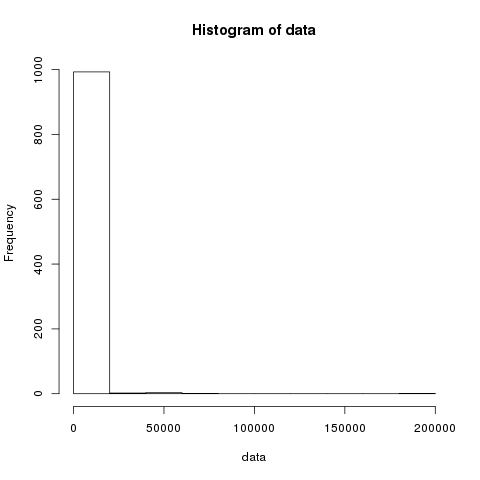

In [16]:
%%R -i data

hist(data)

&nbsp;

Well that looks terrible, I do not even want to mess with that. Maybe a go with [ggplot](http://ggplot2.org/) will work better, but first we need to make a dataframe to feed it. That will require [Pandas](http://pandas.pydata.org/).

&nbsp;

In [17]:
import pandas as pd
df = pd.DataFrame(link_mementos, columns=['link', 'mementos'])

# Print Python Pandas dataframe
df[:5]

,link,mementos
0,www.werkenbijdeloitte.nl,203
1,www.linkedin.com/today/author/jamesljohnson,0
2,www.scmagazine.com/david-beckhams-emails-hacke...,0
3,www.systron.hu,21
4,www.tripwire.com/state-of-security/featured/fr...,1


In [18]:
# Convert Dataframe to be importable by R
from rpy2.robjects import pandas2ri
rdf = pandas2ri.py2ri(df)

&nbsp;

Read in the data using the `-i` flag.
<a id='ggplot'></a>

&nbsp;

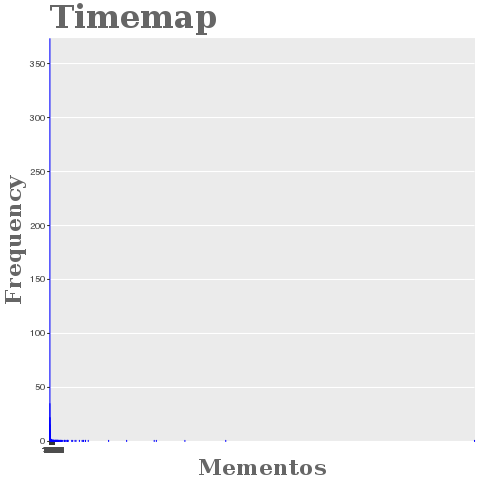

In [23]:
%%R -i rdf

library(ggplot2);

# seq(from, to, by=x)
y_tics <- seq(0, 370, by=50)
x_tics <- seq(0, 2000, by=10)

ggplot(rdf, aes(x=mementos, colour='darkblue')) +
    geom_bar(stat='count', color='blue') +
    xlab('Mementos') +
    ylab('Frequency') +
    ggtitle('Timemap') +
    theme(plot.title = element_text(family = "Trebuchet MS", 
                                    color="#666666", 
                                    face="bold", 
                                    size=32, 
                                    hjust=0)) +
    theme(axis.title = element_text(family = "Trebuchet MS", 
                                    color="#666666", 
                                    face="bold", 
                                    size=22)) +
    theme(panel.grid.minor.x=element_blank(),
          panel.grid.major.x=element_blank()) +
    scale_y_discrete(limits=y_tics) +
    scale_x_discrete(limits=x_tics)

&nbsp;

This is still looking pretty bad, I doubt any R packages could match [plotly](plot.ly) especially considering plotly supports multiple languages and the same plot from earlier could be made with R too. Their documentation also blows everything R has away with excelent examples of all sorts of beautiful charts. The R docs have plenty of examples of utilitarian graphs, zero beautiful ones. Plotly also supports creating interactive graphs from various popular libraries such as ggplot and matplotlib.

<a id='R_plotly'></a>

&nbsp;

In [20]:
%%R -i data

library(plotly);

title_font <- list(
    family = "Courier New, monospace",
    size = 70,
    color = "666666"
)

axis_font <- list(
    family = "Courier New, monospace",
    size = 50,
    color = "666666"
)

tick_font <- list(
    family = "Courier New, monospace",
    size = 30
)

margin <- list(
    l = 200,
    r = 200,
    b = 200,
    t = 200,
    pad = 8
)

p <- plot_ly(x = data, type = "histogram") %>%
     layout(
         title = "Timemap",
         font = title_font,
         xaxis = list(
             title = "Number of Mementos",
             font = axis_font,
             tickfont = tick_font
         ),
         yaxis = list(
             title = "Number of URIs",
             font = axis_font,
             tickfont = tick_font
         ),
         autosize = F,
         resolution = 300,
         width = 2700,
         height = 1440,
         margin = margin
     )

plotly_IMAGE(
    p, 
    format = "png",
    out_file = "histogram.png",
    width=2700,
    height=1440,
    fileopt = "overwrite"
)

&nbsp;

R is throwing a fit about displaying the graph inside the notebook, but it can be viewed directly at the link by clicking the static image below.

&nbsp;

[![graph](histogram.png)](histogram.html)

&nbsp;

It could also been forcefully embedded in an IFrame using IPython.

```
import IPython

IPython.display.IFrame('histogram.html', width=700, height=600)
```

But that is both ugly and slow.


&nbsp;

In [21]:
%%R -i data

q <- plot_ly(x = data, type = "histogram") %>%
     layout(
         title = "Timemap",
         xaxis = list(
             title = "Number of Mementos"
         ),
         yaxis = list(
             title = "Number of URIs"
         )
     )

htmlwidgets::saveWidget(q, "histogram.html")